# Introduction to Pandas

In this notebook, we're going to introduce [Pandas](https://pandas.pydata.org/), an "open source data analysis and manipulation tool." It is, effectively, an extension of the capabilities of NumPy, with a particular focus on two-dimensional data. Check out their [library highlights](https://pandas.pydata.org/about/) for some specific details on what sets Pandas apart from other tools, including NumPy.

In [ ]:
import pandas as pd  # similar import abbreviation to NumPy (np)

To demonstrate the power and utility of Pandas, we're going to use an existing popular open-source dataset. To access it, we first need to install the `huggingface_hub` Python package via `pip`, lets do that first:

In [ ]:
!pip install -qqq huggingface_hub

In [ ]:
df = pd.read_csv("hf://datasets/leostelon/california-housing/housing.csv")

Once we have the data, the first step is to get a feel for what it looks like. We can do this with a very useful method: `head`. This truncates the database to only its first five rows (by default). 

In [ ]:
df.head()

With this, we can get an idea of what we're dealing with. Most columns are numeric values (with one text value in the last column). The rest of this notebook will be dedicated to understanding this dataset using various Pandas methods.

# The dataframe and basic operations

The [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) is essentially a NumPy array, with a few extra bells and whistles. First, and most importantly, it can be heterogeneous. Remember when NumPy tried to cast everything in the array to a common data type? Pandas does not do this. Instead, each column can be a different data type, and Pandas is smart enough to know which methods work on which columns and which do not. The DataFrame, unlike a NumPy array, is two-dimensional. Above, you have already seen your first DataFrame, `df`.

Before diving into the vast number of ways to manipulate DataFrames, let's first focus on the ways we can summarize them. This [blog post](https://medium.com/analytics-vidhya/how-to-summarize-data-with-pandas-2c9edffafbaf) does a good job of listing many of these methods. Here, we will examine a few.

In [ ]:
df.info()

The `info` method provides some nice information in plaintext form about the columns in the data frame, the types of data in each column, and the total memory usage.

In [ ]:
df.describe()

The `describe` method takes the numeric columns, and produces the total non-NaN (null) counts, mean, standard deviation, minimum, maxmimum and quartiles of each column. It is a useful summary of the statistics of the DataFrame.

## DataFrame io

A DataFrame is tabular data, same as any `.csv` file you might read using Microsoft Excel. As such, Pandas provides a few useful methods for writing and reading DataFrames to disk. It is useful to go over and understand these right away, since what good is your data analysis if you cannot save it?

Although there are quite a few arguments you can pass to the `to_csv` and `read_csv` methods, there is really only one common use case which you need to know about.

First, lets write the DataFrame to disk.

In [ ]:
df.to_csv("california_housing.csv", index=False)

You'll notice that if you have the file browser tab on the left open, that the `california_housing.csv` file will appear and can be viewed in your Jupyter Notebook/Lab instance.

Now, lets read it back and make sure it's equal to the original DataFrame.

In [ ]:
df2 = pd.read_csv("california_housing.csv")

It is immediately worth noting that some of the `total_bedrooms` column contains some NaN values. These will be problematic to deal with later on, so for now, we're just going to remove any row in which there is at least one NaN value using the `dropna` method.

In [ ]:
df = df.dropna()

In [ ]:
(df == df2.dropna()).all().all()  # What did we do here?

An interesting subtlety of Python is that `NaN == NaN` is actually _false_. As such, without the `dropna` applied to both DataFrames, the arrays would not be completely equal:

In [ ]:
float('nan') == float('nan')

Anyways, you can see it's quite easy to save and load Pandas DataFrames. A few interesting things to play with:
* What happens if you set `index=False`. when saving the csv?
* Explore, in some detail, the comparison between the two DataFrames, including what happens if you don't drop the NaNs.

## Accessing DataFrame columns

Recall that for NumPy arrays you can access columns via slicing. For example, for a two-dimensional array, you can access the 0th column via `arr[:, 0]`. In Pandas, it's even easier. How do we access a column in a DataFrame? How do we even know which columns there are? Lets start there.

In [ ]:
list(df.columns)

Listing the `df.columns` shows the available columns you can access. To then pull that column from the DataFrame, we can simply use the same syntax as dictionary lookup.

In [ ]:
total_rooms = df["total_rooms"]

`total_rooms` is a slice of the DataFrame, called a Series. It can be easily converted into NumPy arrays, and has many of the same methods defined on it that the DataFrame does.

Another way to access certain slices of the array can be using the `loc` method, which essentially combines NumPy slicing with dictionary lookup. Here's how you can access the same Series using `loc`.

In [ ]:
(df.loc[:, "total_rooms"] == df["total_rooms"]).all()

The final way to access data in a DataFrame is `iloc`. This treats the Pandas Dataframe as, essentially, a NumPy array, and allows for the same lookup and slicing syntax.

In [ ]:
# total_rooms is the 3rd column (zero-indexed) of the dataframe
(df.iloc[:, 3] == df["total_rooms"]).all()

## Adding columns

The Pandas DataFrame is highly mutable, and provides a very easy syntax for adding and removing columns. For example, to add a new column with the number of rooms per household, we take advantage of NumPy element-wise broadcasting syntax and simply do:

In [ ]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]

If you print `df`, you can see `rooms_per_household` is the last column.

## Removing columns

Removing a column is just as easy as adding one, we simply use `drop`. Note that like most operations in Pandas, `drop` is _not_ performed in-place unless specified. To drop the column we just added, in place, we can do:

In [ ]:
df.drop("rooms_per_household", axis=1, inplace=True)

Printing `df` again will now show that column removed, as expected.

## Conversion to NumPy arrays

It is often convenient to lose all of the column names and other "bells and whistles" once a DataFrame is sufficiently processed. We can easily convert a DataFrame to a NumPy array by using the `to_numpy` method. Beware though, you might not get what you expect if not all of the columns are numeric.

In [ ]:
df.to_numpy()  # Note the type of the array due to the "string column"

# Advanced DataFrame manipulation

There are a few more useful ways to manipulate and derive information from DataFrames. In this section, we'll go over applying functions to columns (efficiently), combining tables, determining the correlations between different numeric columns, and finally, some basic plotting of the distributions of columns.

## Applying functions to columns (efficiently)

Sometimes, we want to perform non-trivial transformations of columns element-wise. It's possible that depending on the content of the column, that this may not be possible to vectorize using something like NumPy. Pandas has a solution to this, the `apply` method (you should check out the docs [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)). The `apply` method essentially applies the provided function whatever object it is applied to, be it a DataFrame or Series.

Here's an example in which the function simply appends the letter "s" to the end of the element of the column.

In [ ]:
def apply_s(x):
    return x + "s"

In [ ]:
df["ocean_proximity"].apply(apply_s)

Of course, this would be problematic if you tried to apply it to a numeric column (how do you add a float or int with a string?), so use this method with caution.

## Combining DataFrames

Operations that fuse DataFrames together are extremely important in data science. If you've ever dealt with SQL, there are similar operations to e.g. join two tables together. It's always useful to know how these methods work.

Lets start with concatenation. Given two DataFrames that share the same column labels, we can "stack" them using `pd.concat`. To see how this works, lets stack the `head` and `tail` of `df` into a new DataFrame.

In [ ]:
pd.concat([df.head(), df.tail()])

Notice how the first and last 5 rows were combined.

Another way to combine two DataFrames is via `merge`. This is slightly more complicated, but you can think of it as combining two DataFrames with the same number of rows, but different columns. In that case, the merge application becomes a bit complex. It's best demonstrated by example:

In [ ]:
df1 = df[["longitude", "latitude", "total_bedrooms"]]
df2 = df[["longitude", "latitude", "median_income", "population"]]

Notice that `df1` and `df2` share both the `longitude` and `latitude` columns, and that the data in these columns is the same. Lets now try to merge them.

In [ ]:
pd.merge(df1, df2)

By default, Pandas detects that the `longitude` and `latitude` columns are shared between the two DataFrames and does not duplicate that information. There are _many_ ways to execute a `merge` operation, and careful study of the [Pandas documentation on merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) is strongly recommended!

## Correlation

Pandas offers a nice `corr` method for computing the linear correlations between numerical columns in the DataFrame. The correlation, or linear correlation to be more specific, captures the structure of how one variable changes when another changes. For example, if $y$ is always increasing when $x$ increases, then these variables are perfectly linearly correlated (correlation coefficient of $1$). If $y$ is always decreasing when $x$ increases, then these variables are perfectly anti-correlated (correlation coefficient of $-1$). There are of course various degrees of correlation. Some examples of data with various correlation coefficients are shown below.

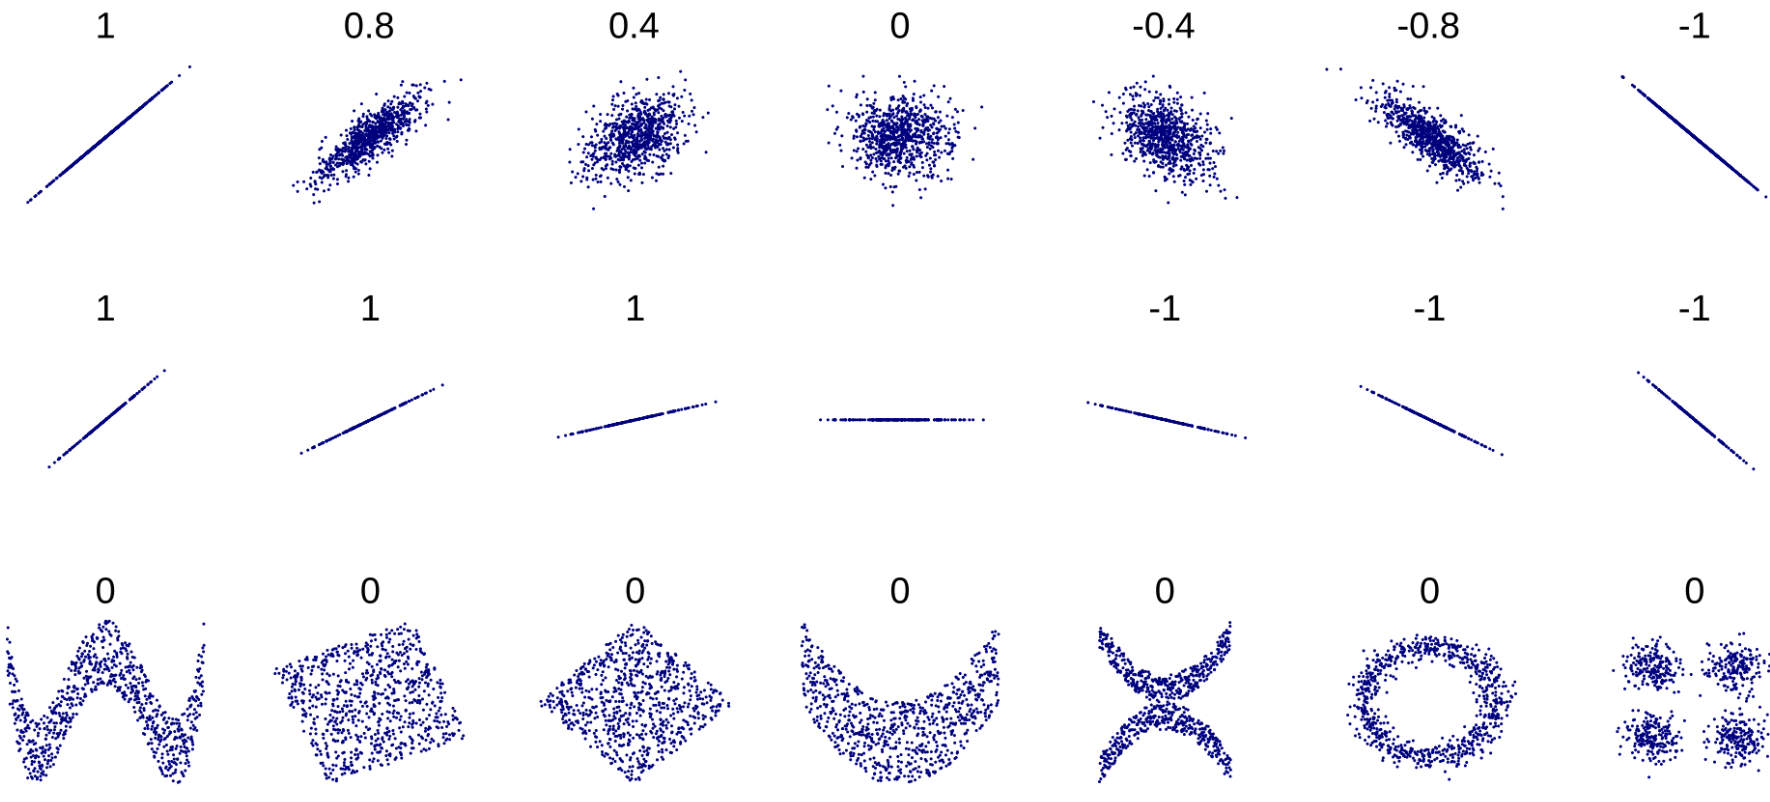

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

Note that the linear correlation can only capture _linear_ structure, as showcased by the third row.

Pandas offers a very easy way to compute the correlation coefficient between all pairs of columns. Lets see this in action with our `df` DataFrame.

In [ ]:
df.corr(numeric_only=True)

What pops out at us here? Here are a few neat observations:
* The longitude and latitude are almost perfectly anti-correlated. Why might this be? Remember this is California!
* Total bedrooms and total rooms are strongly correlated.

TK